In [1]:
!pip install keras==2.15.0

In [2]:
import keras
print("Keras version:", keras.__version__)

2024-04-29 10:42:11.713820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 10:42:11.713875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 10:42:11.715711: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Keras version: 2.15.0


In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, concatenate, Flatten, Dense, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import activations
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from keras.layers import Conv2D, Input, Flatten, Dense, BatchNormalization, LeakyReLU, \
    MaxPooling2D, Dropout, Concatenate, Activation
import random
import numpy as np
from keras.datasets import cifar10
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
import keras
from sklearn.metrics import classification_report

In [4]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.15.0
Keras version: 2.15.0


In [5]:
SIZE = (128, 128)

folder_aircrafts_path = '/kaggle/input/rfaircrafts/olehratinskiy_diploma_dataset/'

types = ['attack_helicopters', 'fighter_aircrafts', 'il-76', 'tu-22', 'tu-95', 'tu-160', 'noaircrafts']

img_list = []
labels = []

for idx, aircraft_type in enumerate(types):
    for filename in sorted(os.listdir(folder_aircrafts_path + aircraft_type + '/')):
        img_path = os.path.join(folder_aircrafts_path + aircraft_type + '/', filename)
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, SIZE)
        img_list.append(img_resized)
        labels.append(idx)

X = np.array(img_list)
labels = np.array(labels)

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    dtype='uint8'
)

updated_images = []
updated_labels = []

for img, label in zip(X_train, y_train):
    img = img.reshape((1,) + img.shape)
    for _ in range(30):
        new_img = datagen.flow(img, batch_size=1)[0][0]
        updated_images.append(new_img)
        updated_labels.append(label)

X_train = np.array(updated_images)
y_train = np.array(updated_labels)


updated_images = []
updated_labels = []

for img, label in zip(X_test, y_test):
    img = img.reshape((1,) + img.shape)
    for _ in range(30):
        new_img = datagen.flow(img, batch_size=1)[0][0]
        updated_images.append(new_img)
        updated_labels.append(label)

X_test = np.array(updated_images)
y_test = np.array(updated_labels)


updated_images = []
updated_labels = []

for img, label in zip(X_val, y_val):
    img = img.reshape((1,) + img.shape)
    for _ in range(30):
        new_img = datagen.flow(img, batch_size=1)[0][0]
        updated_images.append(new_img)
        updated_labels.append(label)

X_val = np.array(updated_images)
y_val = np.array(updated_labels)

In [8]:
print(len(X_train), len(X_test), len(X_val))
print(len(y_train), len(y_test), len(y_val))

20880 2640 2610
20880 2640 2610


In [9]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

y_train_one_hot = to_categorical(y_train, len(types))
y_val_one_hot = to_categorical(y_val, len(types))
y_test_one_hot = to_categorical(y_test, len(types))

In [10]:
shape = (128, 128, 3) 

In [11]:
vgg_model = VGG16(include_top=True,
                  weights=None,
                  input_shape=shape,
                  pooling='max',
                  classes=len(types),
                  classifier_activation='softmax')
vgg_model.compile(keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [12]:
history_vgg = vgg_model.fit(X_train, y_train_one_hot, epochs=100, batch_size=16, validation_data=(X_val, y_val_one_hot)) 

Epoch 1/100


I0000 00:00:1714387447.246815     910 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1305/1305 [==============================] - 77s 52ms/step - loss: 1.6173 - accuracy: 0.3700 - val_loss: 1.2923 - val_accuracy: 0.5464
Epoch 2/100
1305/1305 [==============================] - 66s 51ms/step - loss: 1.0237 - accuracy: 0.6258 - val_loss: 0.8929 - val_accuracy: 0.7065
Epoch 3/100
1305/1305 [==============================] - 66s 51ms/step - loss: 0.7808 - accuracy: 0.7102 - val_loss: 0.8822 - val_accuracy: 0.6770
Epoch 4/100
1305/1305 [==============================] - 67s 51ms/step - loss: 0.6290 - accuracy: 0.7647 - val_loss: 0.9182 - val_accuracy: 0.7471
Epoch 5/100
1305/1305 [==============================] - 67s 51ms/step - loss: 0.5029 - accuracy: 0.8153 - val_loss: 1.0250 - val_accuracy: 0.7467
Epoch 6/100
1305/1305 [==============================] - 66s 51ms/step - loss: 0.3869 - accuracy: 0.8579 - val_loss: 1.1307 - val_accuracy: 0.7805
Epoch 7/100
1305/1305 [==============================] - 66s 51ms/step - loss: 0.2992 - accuracy: 0.8897 - val_loss: 1.4532 - val_

In [13]:
predictions = vgg_model.predict(X_test)  
predicted_labels = np.argmax(predictions, axis=1)  
accuracy_result = accuracy_score(y_test, predicted_labels) 

print("Test samples accuracy:", accuracy_result)   

83/83 [==============================] - 4s 23ms/step
Test samples accuracy: 0.8590909090909091


In [14]:
y_test_encoded = tf.keras.utils.to_categorical(y_test)
test_loss = vgg_model.evaluate(X_test, y_test_encoded, verbose=0)
print("Test loss:", test_loss)

Test loss: [1.172715663909912, 0.8590909242630005]


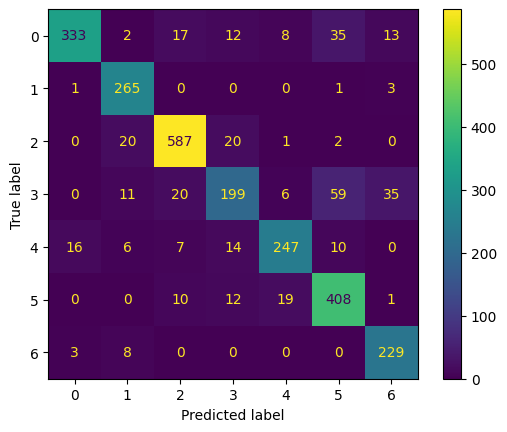

In [18]:
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, predicted_labels)
ConfusionMatrixDisplay(cm).plot()

In [19]:
classification_results = classification_report(y_test, predicted_labels, target_names=types)

print("Classification results:\n", classification_results)

Classification results:
                     precision    recall  f1-score   support

attack_helicopters       0.94      0.79      0.86       420
 fighter_aircrafts       0.85      0.98      0.91       270
             il-76       0.92      0.93      0.92       630
             tu-22       0.77      0.60      0.68       330
             tu-95       0.88      0.82      0.85       300
            tu-160       0.79      0.91      0.85       450
       noaircrafts       0.81      0.95      0.88       240

          accuracy                           0.86      2640
         macro avg       0.85      0.86      0.85      2640
      weighted avg       0.86      0.86      0.86      2640



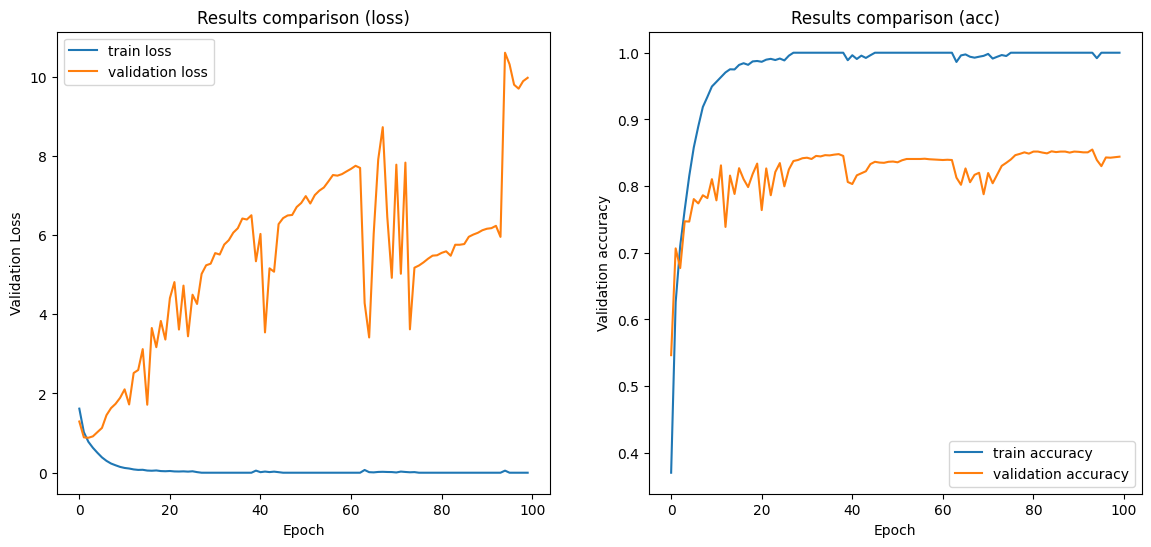

In [24]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['loss'], label='train loss')
plt.plot(history_vgg.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Results comparison (loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['accuracy'], label='train accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Results comparison (acc)')
plt.legend()
plt.show()